In [ ]:
import pandas as pd
import numpy as np
import os
import glob
import cv2
# from keras.preprocessing import image   # for preprocessing the images
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv3D, MaxPooling3D, Dropout, BatchNormalization
# from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras import models
from keras import layers
import keras
# from keras.layers import TimeDistributed, Conv2D, Dense, MaxPooling2D, Flatten, LSTM, Dropout, BatchNormalization
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt    
%matplotlib inline

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
#unzipping and making directories
! mkdir train_dir
! unzip '/content/gdrive/MyDrive/Training_Drinking.zip' -d train_dir

mkdir: cannot create directory ‘train_dir’: File exists
Archive:  /content/gdrive/MyDrive/Training_Drinking.zip
replace train_dir/Training_Drinking/drinking_0.avi? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
! mkdir frame_dir

In [ ]:
#fuction gets the video and save the frames of videos to .jpg format
def get_frames(video_path, dest_path):
    file_name = video_path.split('.')[0].split('/')[-1]
    cap= cv2.VideoCapture(video_path)
    total_frames = int(cap.get(7))
    frame_rate = cap.get(5)
    # print(file_name,total_frames,frame_rate)
    frame_distance = total_frames//10
    
    count=0
    frame_count=0
    for i in range (total_frames): #iterating over all the frames of the video.
        ret, frame = cap.read()
        if ret ==False:  # Checking if the frame is missing, and if missing, we take the previous frame
            frame = f_prev
        elif ret==True:
            f_prev =frame
        frame_count +=1
        if ((frame_count ==(frame_distance)) and (count<10)):
            frame_count = 0
            cv2.imwrite(dest_path+'/'+file_name+'_'+ str(count)+".jpg",frame)
            count +=1
    cap.release()
    cv2.destroyAllWindows()

In [ ]:
video_dir='/content/train_dir/Training_Drinking'
frame_dir='/content/frame_dir'

In [ ]:
#save the frames of all videos
for i in range(len(os.listdir(video_dir))):
    video_path = video_dir + '/' + os.listdir(video_dir)[i]
    get_frames(video_path,frame_dir)
print("All frames written in the frame_dir Folder")

All frames written in the frame_dir Folder


In [ ]:
img_high=224
img_width=224
frame_no_video=10

In [ ]:
def get_train_data(file_name):
    training = []
    frames_to_select=[]
    for i , filename in enumerate(glob.glob(file_name)):

        image = cv2.imread(filename)
        img = cv2.resize(image, dsize=(img_high,img_width), interpolation=cv2.INTER_CUBIC)
        # normalizing the pixel value
        img = img/255
        training.append(img)
    return training


In [ ]:
training = get_train_data(frame_dir + '/*.jpg')

In [ ]:
# put label 1 for drinking and 0 for others
train_label =[]
for file in os.listdir(frame_dir):
    label = file.split('_')[0]
    if label == 'drinking':
        train_label.append(1)
    else:
        train_label.append(0)
print(len(train_label))


1800


In [ ]:
vid_num=len(train_label)//frame_no_video
X = np.asarray(training)
y = np.asarray(train_label)
print(y.shape)
print(X.shape)

(1800,)
(1800, 224, 224, 3)


In [ ]:
# split data to train and validation
x_train, x_valid, y_train, y_valid = train_test_split(X,y, test_size=0.4) 

In [ ]:
# Transfer Learning using pre-trained model

from keras.applications import VGG16
conv_base = VGG16(weights= 'imagenet', include_top=False, input_shape=(x_train.shape[1], x_train.shape[2], 3))

#if you don't give the input shape, it will retrieve it from data
#conv_base.summary()

In [ ]:
conv_base.trainable = False

In [ ]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))
          
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               12845568  
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0

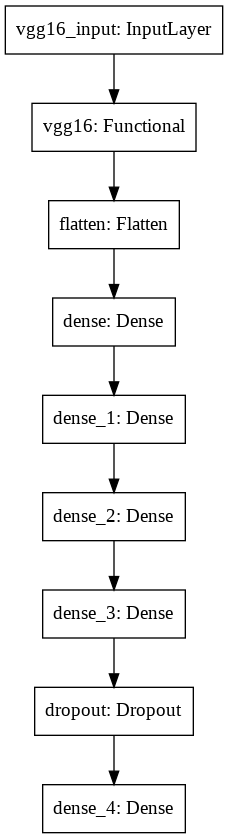

In [ ]:
plot_model(model, to_file='vgg.png')

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

In [ ]:
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

datagen.fit(x_train)

In [ ]:
validation_datagen = ImageDataGenerator()       # no augmentation for validation set
validation_datagen.fit(x_valid)

In [ ]:
from keras.callbacks import ModelCheckpoint
path = F"/content/gdrive/MyDrive/model3.h5" 
checkpoint = ModelCheckpoint(path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [ ]:
epochs = 10
history = model.fit(datagen.flow(x_train, y_train, batch_size=32),
                    steps_per_epoch=len(x_train) / 32, epochs=epochs,
                              validation_data=validation_datagen.flow(x_valid, y_valid, batch_size=32),callbacks=[checkpoint])

Epoch 1/10
33/33 [==============================] - 61s 666ms/step - loss: 0.6657 - acc: 0.5670 - val_loss: 0.6694 - val_acc: 0.5458

Epoch 00001: val_loss improved from inf to 0.66945, saving model to /content/gdrive/MyDrive/model3.h5
Epoch 2/10
33/33 [==============================] - 15s 443ms/step - loss: 0.5555 - acc: 0.5332 - val_loss: 0.6063 - val_acc: 0.5458

Epoch 00002: val_loss improved from 0.66945 to 0.60630, saving model to /content/gdrive/MyDrive/model3.h5
Epoch 3/10
33/33 [==============================] - 15s 444ms/step - loss: 0.4568 - acc: 0.5575 - val_loss: 0.5544 - val_acc: 0.5458

Epoch 00003: val_loss improved from 0.60630 to 0.55436, saving model to /content/gdrive/MyDrive/model3.h5
Epoch 4/10
33/33 [==============================] - 15s 448ms/step - loss: 0.4125 - acc: 0.5645 - val_loss: 0.5434 - val_acc: 0.5458

Epoch 00004: val_loss improved from 0.55436 to 0.54340, saving model to /content/gdrive/MyDrive/model3.h5
Epoch 5/10
33/33 [==========================

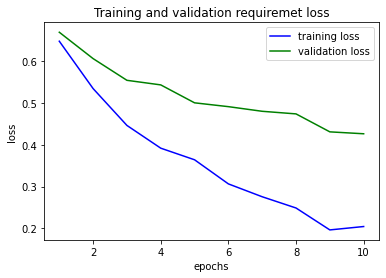

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot Training and Validation loss over epoch
epochs = range(1,11)
plt.plot(epochs, loss , 'b', label = 'training loss')
plt.plot(epochs, val_loss, 'g', label = 'validation loss')
plt.title('Training and validation requiremet loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend()


In [ ]:
! mkdir test_dir
! unzip '/content/gdrive/MyDrive/Test_Drinking.zip' -d test_dir
! mkdir frames_test

Archive:  /content/gdrive/MyDrive/Test_Drinking.zip
   creating: test_dir/Test_Drinking/
  inflating: test_dir/Test_Drinking/drinking_0.avi  
  inflating: test_dir/Test_Drinking/drinking_1.avi  
  inflating: test_dir/Test_Drinking/drinking_10.avi  
  inflating: test_dir/Test_Drinking/drinking_11.avi  
  inflating: test_dir/Test_Drinking/drinking_12.avi  
  inflating: test_dir/Test_Drinking/drinking_13.avi  
  inflating: test_dir/Test_Drinking/drinking_14.avi  
  inflating: test_dir/Test_Drinking/drinking_15.avi  
  inflating: test_dir/Test_Drinking/drinking_16.avi  
  inflating: test_dir/Test_Drinking/drinking_17.avi  
  inflating: test_dir/Test_Drinking/drinking_18.avi  
  inflating: test_dir/Test_Drinking/drinking_19.avi  
  inflating: test_dir/Test_Drinking/drinking_2.avi  
  inflating: test_dir/Test_Drinking/drinking_20.avi  
  inflating: test_dir/Test_Drinking/drinking_21.avi  
  inflating: test_dir/Test_Drinking/drinking_22.avi  
  inflating: test_dir/Test_Drinking/drinking_23.av

In [ ]:
test_dir='/content/test_dir/Test_Drinking'
frames_test='/content/frames_test'

In [ ]:
#save the frames of all videos
for i in range(len(os.listdir(test_dir))):
    video_path = test_dir + '/' + os.listdir(test_dir)[i]
    get_frames(video_path,frames_test)
print("All frames written in the frame_dir Folder")

All frames written in the frame_dir Folder


In [ ]:
testing = get_train_data(frames_test + '/*.jpg')

In [ ]:
test_label =[]
for file in os.listdir(frames_test):
    label = file.split('_')[0]
    if label == 'drinking':
        test_label.append(1)
    else:
        test_label.append(0)
print(len(test_label))

400


In [ ]:
vid_num=len(test_label)//frame_no_video
X_test = np.asarray(testing)
y_test = np.asarray(test_label)
print(X_test.shape)
print(y_test.shape)

(400, 224, 224, 3)
(400,)


In [ ]:
scores = model.evaluate(X_test, y_test)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

13/13 [==============================] - 2s 117ms/step - loss: 0.7586 - acc: 0.7500
acc: 75.00%
